In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow

EXTRACTION OF PRETRAINED NETWORK FROM KERAS


In [ ]:
img_height, img_width = (224,224)
batch_size = 32

train_data_dir = r"G:/TARP/train"
valid_data_dir = r"G:/TARP/val"
test_data_dir = r"G:/TARP/test"
#test_data_dir = r"/content/drive/MyDrive/outputfolder/test"
#image.open()

In [ ]:

train_datagen = ImageDataGenerator(
                                     shear_range=0.2,zoom_range=0.2,
                                 horizontal_flip=True,
                                   validation_split=0.4)
                                   # rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                      class_mode='categorical')
                       
                                       #   subset='training')# set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as validation data  
                                                                                                       

Found 2380 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'Aug_overvol': 0, 'aug_normal': 1, 'non_overload_vehicles': 2}

In [ ]:
y_train = train_generator.classes
len(y_train)

2380

In [ ]:
nb_validation_samples = 306

In [ ]:
dir(train_generator)
#type(train_generator.labels)
print(train_generator.classes)
#y_train = train_generator.classes
y_train = train_generator.classes
y_train.shape

[0 0 0 ... 2 2 2]


(2380,)

In [ ]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                   
                                                   batch_size = 1, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as testing data

Found 301 images belonging to 3 classes.


In [ ]:
x,y = test_generator.next()
x.shape
#print(type(x))
#x

(1, 224, 224, 3)

RESNET50
ARCHITECTURE

In [ ]:
def create_model():

  base_model_3 = ResNet50(include_top = False, weights='imagenet')
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
#checkpoint_path = "C:/Users/DHANVANTH/SAMSUNG/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "G:/TARP/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.000001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.8891 - mse: 0.0530
Epoch 00001: val_accuracy improved from -inf to 0.95833, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 484s 6s/step - loss: 0.2871 - accuracy: 0.8891 - mse: 0.0530 - val_loss: 0.1445 - val_accuracy: 0.9583 - val_mse: 0.0243
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9584 - mse: 0.0200
Epoch 00002: val_accuracy improved from 0.95833 to 0.96875, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 415s 6s/step - loss: 0.1136 - accuracy: 0.9584 - mse: 0.0200 - val_loss: 0.1377 - val_accuracy: 0.9688 - val_mse: 0.0204
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9702 - mse: 0.0140
Epoch 00003: val_accuracy did not improve from 0.96875
75/75 [==============================] - 402s 5s/ste

75/75 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9912 - mse: 0.0042
Epoch 00025: val_accuracy did not improve from 0.98264
75/75 [==============================] - 297s 4s/step - loss: 0.0244 - accuracy: 0.9912 - mse: 0.0042 - val_loss: 0.0627 - val_accuracy: 0.9688 - val_mse: 0.0119
Epoch 26/30
75/75 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9908 - mse: 0.0043
Epoch 00026: val_accuracy improved from 0.98264 to 0.98958, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 301s 4s/step - loss: 0.0248 - accuracy: 0.9908 - mse: 0.0043 - val_loss: 0.0616 - val_accuracy: 0.9896 - val_mse: 0.0097
Epoch 27/30
75/75 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9929 - mse: 0.0038
Epoch 00027: val_accuracy did not improve from 0.98958
75/75 [==============================] - 307s 4s/step - loss: 0.0235 - accuracy: 0.9929 - mse: 0.0038 - val_loss: 0.0773 - val_

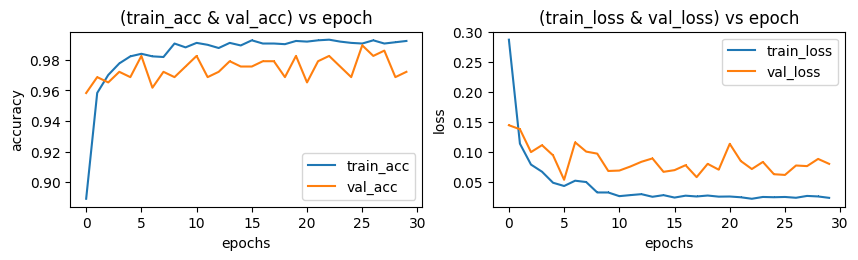

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
#f.savefig('C:/Users/DHANVANTH/SAMSUNG/resnet_50_epoch_vs_acc', bbox_inches='tight', dpi=600)

In [ ]:
#model_1 = tensorflow.keras.models.load_model('RESNET_epoch_100.h5')

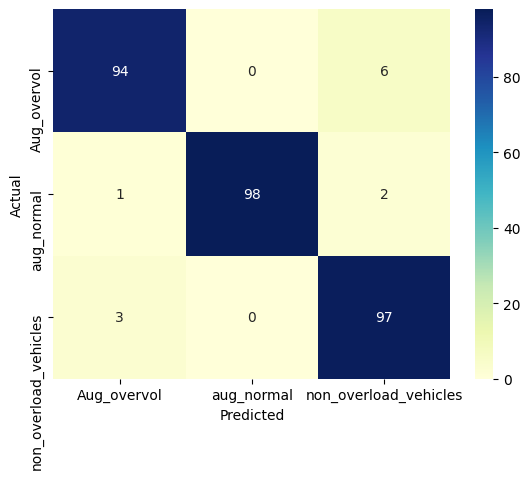

test accuracy: 96.01328903654485


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Aug_overvol', 'aug_normal', 'non_overload_vehicles']

ROC AUC score: 0.9701794510907812


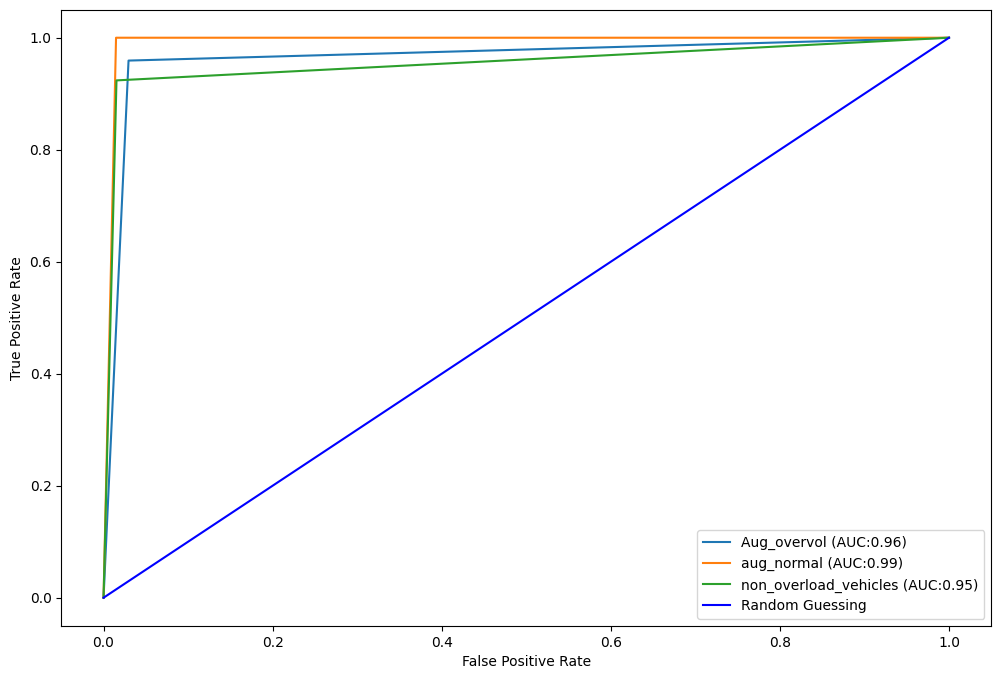

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#mobilenet
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow

In [ ]:
def create_model():

  base_model_3 = MobileNetV2(include_top = False, weights='imagenet')
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
#checkpoint_path = "C:/Users/DHANVANTH/SAMSUNG/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "G:/TARP/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.000001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.6962 - mse: 0.1366
Epoch 00001: val_accuracy improved from -inf to 0.73611, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 288s 4s/step - loss: 0.7053 - accuracy: 0.6962 - mse: 0.1366 - val_loss: 0.6196 - val_accuracy: 0.7361 - val_mse: 0.1194
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.8294 - mse: 0.0855
Epoch 00002: val_accuracy improved from 0.73611 to 0.77778, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 283s 4s/step - loss: 0.4582 - accuracy: 0.8294 - mse: 0.0855 - val_loss: 0.5185 - val_accuracy: 0.7778 - val_mse: 0.1018
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8584 - mse: 0.0681
Epoch 00003: val_accuracy improved from 0.77778 to 0.78819, saving model to G:/TARP/Resnet\cp-0021.ckpt.dat

Epoch 25/30
75/75 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9193 - mse: 0.0401
Epoch 00025: val_accuracy did not improve from 0.88194
75/75 [==============================] - 281s 4s/step - loss: 0.2244 - accuracy: 0.9193 - mse: 0.0401 - val_loss: 0.3491 - val_accuracy: 0.8507 - val_mse: 0.0680
Epoch 26/30
75/75 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9227 - mse: 0.0392
Epoch 00026: val_accuracy did not improve from 0.88194
75/75 [==============================] - 282s 4s/step - loss: 0.2208 - accuracy: 0.9227 - mse: 0.0392 - val_loss: 0.3405 - val_accuracy: 0.8611 - val_mse: 0.0619
Epoch 27/30
75/75 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9214 - mse: 0.0397
Epoch 00027: val_accuracy did not improve from 0.88194
75/75 [==============================] - 283s 4s/step - loss: 0.2233 - accuracy: 0.9214 - mse: 0.0397 - val_loss: 0.3081 - val_accuracy: 0.8819 - val_mse: 0.0574
Epoch 28/30
75/75 [===

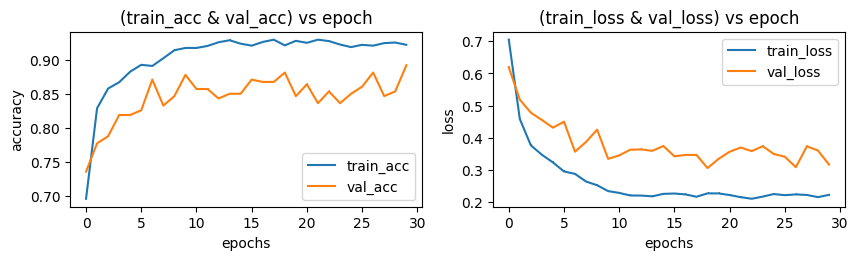

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
#f.savefig('C:/Users/DHANVANTH/SAMSUNG/resnet_50_epoch_vs_acc', bbox_inches='tight', dpi=600)

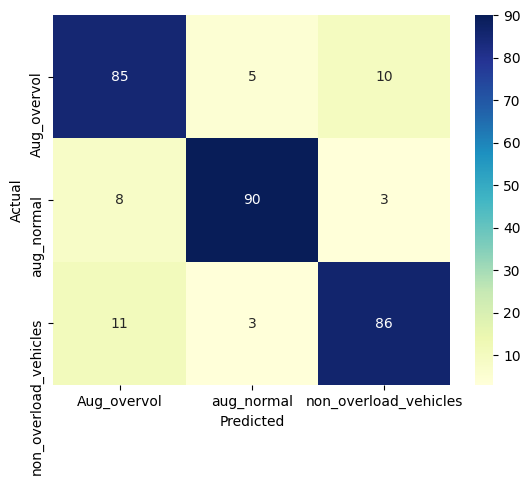

test accuracy: 86.71096345514951


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Aug_overvol', 'aug_normal', 'non_overload_vehicles']

ROC AUC score: 0.9001818726045043


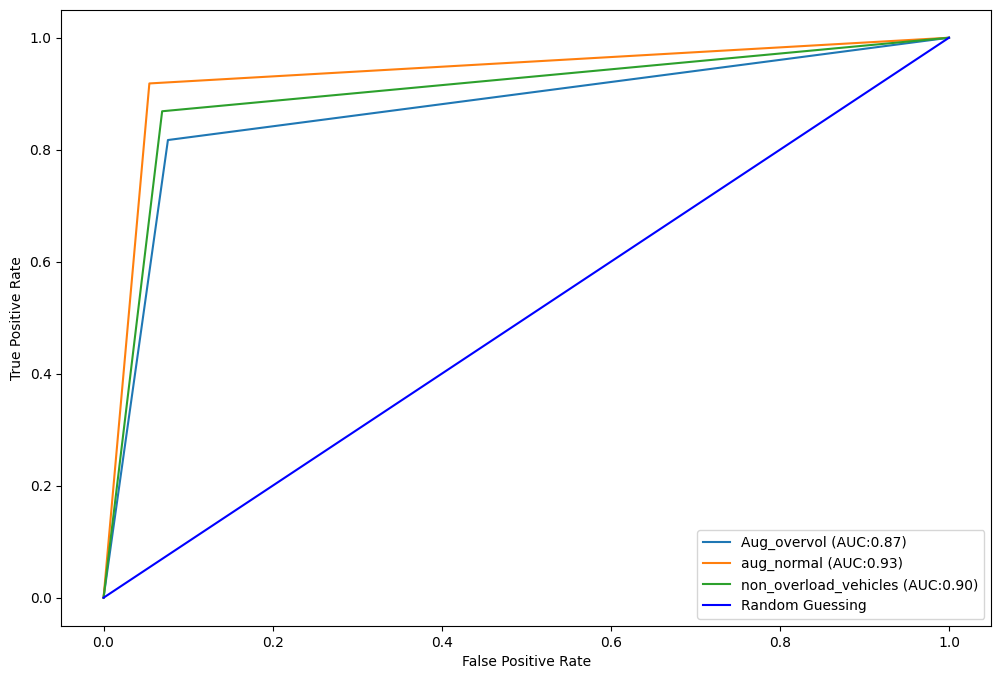

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#Eb0
from tensorflow.keras.applications.efficientnet import EfficientNetB0


In [ ]:
def create_model():

  base_model_3 = EfficientNetB0(include_top = False, weights='imagenet')
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_______________________________________________________________________________________

In [ ]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
#checkpoint_path = "C:/Users/DHANVANTH/SAMSUNG/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "G:/TARP/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.8887 - mse: 0.0610
Epoch 00001: val_accuracy improved from -inf to 0.92361, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 292s 4s/step - loss: 0.3464 - accuracy: 0.8887 - mse: 0.0610 - val_loss: 0.2509 - val_accuracy: 0.9236 - val_mse: 0.0451
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9534 - mse: 0.0255
Epoch 00002: val_accuracy improved from 0.92361 to 0.93750, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 290s 4s/step - loss: 0.1526 - accuracy: 0.9534 - mse: 0.0255 - val_loss: 0.1747 - val_accuracy: 0.9375 - val_mse: 0.0313
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9630 - mse: 0.0198
Epoch 00003: val_accuracy did not improve from 0.93750
75/75 [==============================] - 286s 4s/ste

75/75 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9870 - mse: 0.0077
Epoch 00025: val_accuracy did not improve from 0.97222
75/75 [==============================] - 286s 4s/step - loss: 0.0484 - accuracy: 0.9870 - mse: 0.0077 - val_loss: 0.1162 - val_accuracy: 0.9618 - val_mse: 0.0215
Epoch 26/30
75/75 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9853 - mse: 0.0087
Epoch 00026: val_accuracy did not improve from 0.97222
75/75 [==============================] - 311s 4s/step - loss: 0.0519 - accuracy: 0.9853 - mse: 0.0087 - val_loss: 0.1174 - val_accuracy: 0.9549 - val_mse: 0.0208
Epoch 27/30
75/75 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9857 - mse: 0.0087
Epoch 00027: val_accuracy did not improve from 0.97222
75/75 [==============================] - 290s 4s/step - loss: 0.0525 - accuracy: 0.9857 - mse: 0.0087 - val_loss: 0.1130 - val_accuracy: 0.9514 - val_mse: 0.0215
Epoch 28/30
75/75 [===============

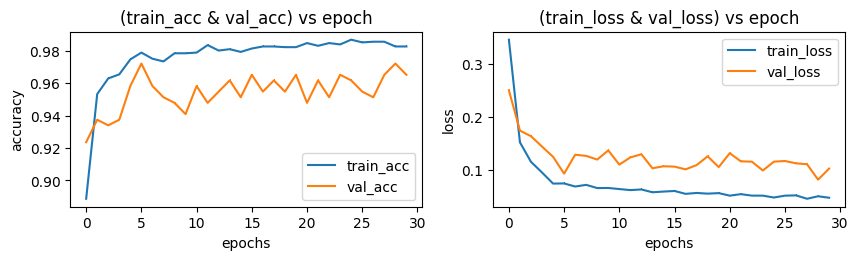

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
#f.savefig('C:/Users/DHANVANTH/SAMSUNG/resnet_50_epoch_vs_acc', bbox_inches='tight', dpi=600)

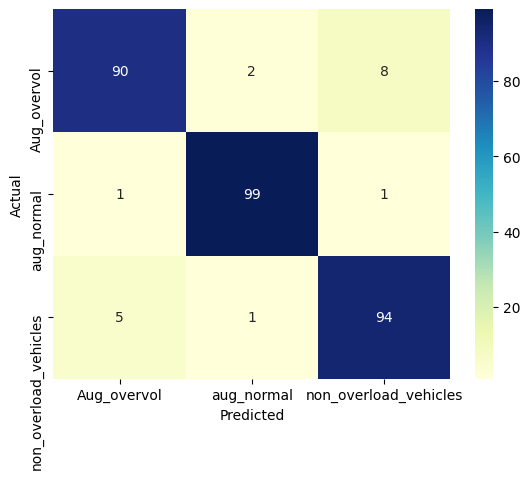

test accuracy: 94.01993355481729


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Aug_overvol', 'aug_normal', 'non_overload_vehicles']

ROC AUC score: 0.955433115317905


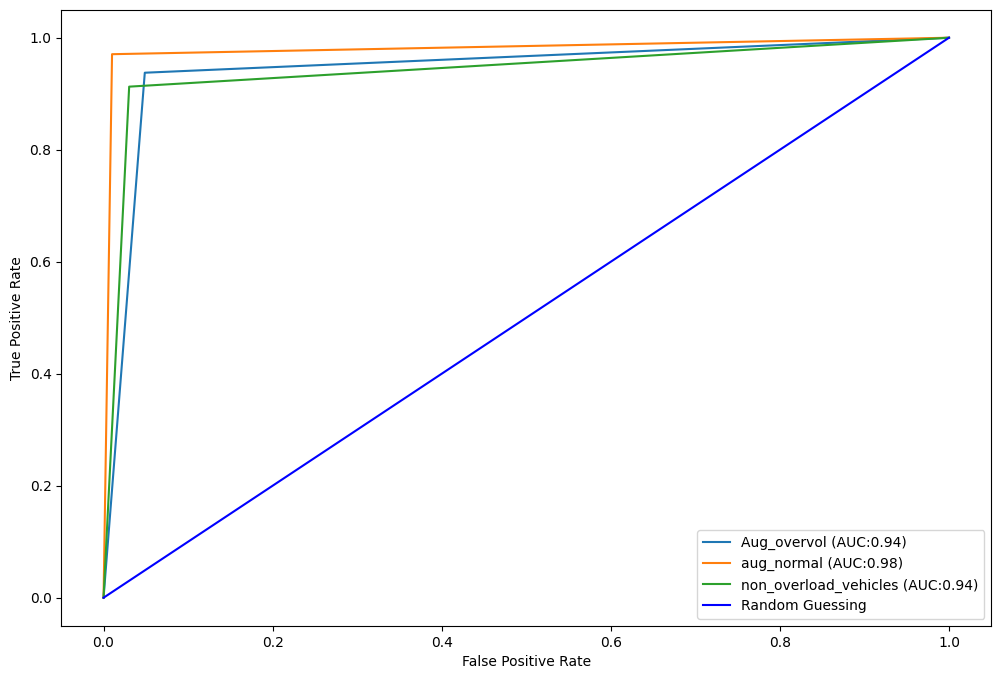

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
#enb3

In [ ]:
def create_model():

  base_model_3 = EfficientNetB3(include_top = False, weights='imagenet')
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_______________________________________________________________________________________

Total params: 12,360,498
Trainable params: 1,576,963
Non-trainable params: 10,783,535
__________________________________________________________________________________________________


In [ ]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
#checkpoint_path = "C:/Users/DHANVANTH/SAMSUNG/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "G:/TARP/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.8882 - mse: 0.0601
Epoch 00001: val_accuracy improved from -inf to 0.90278, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 451s 6s/step - loss: 0.3378 - accuracy: 0.8882 - mse: 0.0601 - val_loss: 0.2451 - val_accuracy: 0.9028 - val_mse: 0.0465
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9487 - mse: 0.0263
Epoch 00002: val_accuracy improved from 0.90278 to 0.93403, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 409s 5s/step - loss: 0.1515 - accuracy: 0.9487 - mse: 0.0263 - val_loss: 0.1860 - val_accuracy: 0.9340 - val_mse: 0.0342
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9542 - mse: 0.0214
Epoch 00003: val_accuracy improved from 0.93403 to 0.94444, saving model to G:/TARP/Resnet\cp-0021.ckpt.dat

Epoch 25/30
75/75 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9861 - mse: 0.0071
Epoch 00025: val_accuracy did not improve from 0.97222
75/75 [==============================] - 300s 4s/step - loss: 0.0432 - accuracy: 0.9861 - mse: 0.0071 - val_loss: 0.0980 - val_accuracy: 0.9722 - val_mse: 0.0172
Epoch 26/30
75/75 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9870 - mse: 0.0075
Epoch 00026: val_accuracy did not improve from 0.97222
75/75 [==============================] - 299s 4s/step - loss: 0.0465 - accuracy: 0.9870 - mse: 0.0075 - val_loss: 0.1135 - val_accuracy: 0.9583 - val_mse: 0.0205
Epoch 27/30
75/75 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9861 - mse: 0.0073
Epoch 00027: val_accuracy did not improve from 0.97222
75/75 [==============================] - 299s 4s/step - loss: 0.0442 - accuracy: 0.9861 - mse: 0.0073 - val_loss: 0.0961 - val_accuracy: 0.9653 - val_mse: 0.0164
Epoch 28/30
75/75 [===

<Figure size 640x480 with 0 Axes>

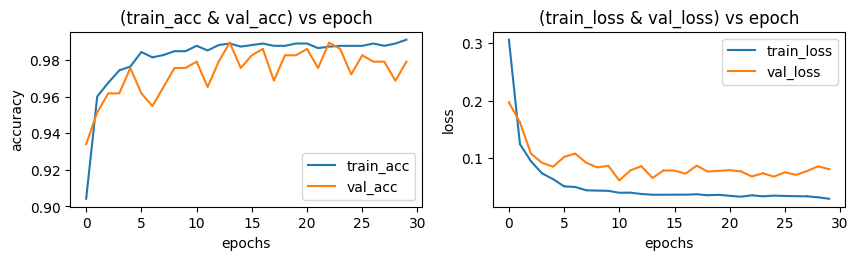

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
#f.savefig('C:/Users/DHANVANTH/SAMSUNG/resnet_50_epoch_vs_acc', bbox_inches='tight', dpi=600)

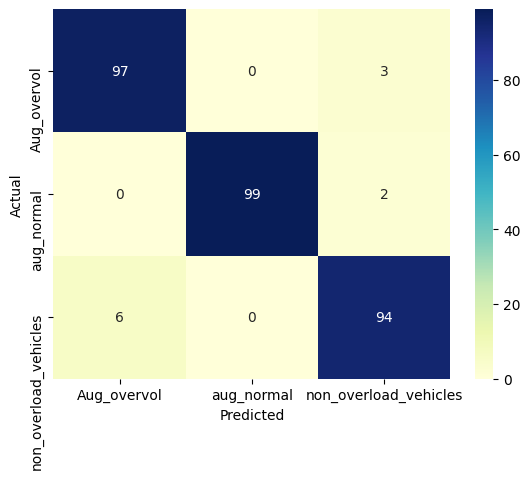

test accuracy: 96.3455149501661


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Aug_overvol', 'aug_normal', 'non_overload_vehicles']

ROC AUC score: 0.9726222622262226


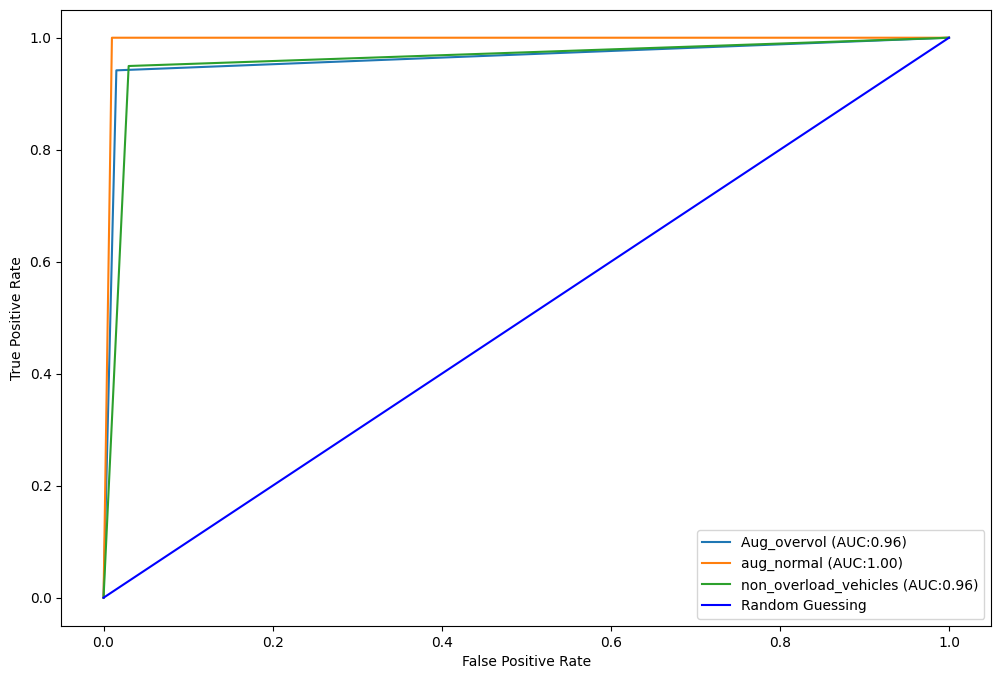

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#eb4
from tensorflow.keras.applications.efficientnet import EfficientNetB4
img_height, img_width = (380,380)
batch_size = 32

train_data_dir = r"G:/TARP/train"
valid_data_dir = r"G:/TARP/val"
test_data_dir = r"G:/TARP/test"
#test_data_dir = r"/content/drive/MyDrive/outputfolder/test"
#image.open()

In [ ]:

train_datagen = ImageDataGenerator(
                                     shear_range=0.2,zoom_range=0.2,
                                 horizontal_flip=True,
                                   validation_split=0.4)
                                   # rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                      class_mode='categorical')
                       
                                       #   subset='training')# set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as validation data  
                                                                                                       

Found 2380 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [ ]:
y_train = train_generator.classes
len(y_train)
nb_validation_samples = 304
dir(train_generator)
#type(train_generator.labels)
print(train_generator.classes)
#y_train = train_generator.classes
y_train = train_generator.classes
y_train.shape

[0 0 0 ... 2 2 2]


(2380,)

In [ ]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                   
                                                   batch_size = 1, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as testing data

Found 301 images belonging to 3 classes.


In [ ]:
x,y = test_generator.next()
x.shape
#print(type(x))
#x

(1, 380, 380, 3)

In [ ]:
def create_model():

  base_model_3 = EfficientNetB4(include_top = False, weights='imagenet')
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_2[0][0]            
______________________________________________________________________________________

Total params: 19,512,930
Trainable params: 1,839,107
Non-trainable params: 17,673,823
__________________________________________________________________________________________________


In [ ]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
#checkpoint_path = "C:/Users/DHANVANTH/SAMSUNG/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "G:/TARP/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.9042 - mse: 0.0533 
Epoch 00001: val_accuracy improved from -inf to 0.93403, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 896s 12s/step - loss: 0.3063 - accuracy: 0.9042 - mse: 0.0533 - val_loss: 0.1971 - val_accuracy: 0.9340 - val_mse: 0.0346
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9601 - mse: 0.0212 
Epoch 00002: val_accuracy improved from 0.93403 to 0.95139, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
75/75 [==============================] - 878s 12s/step - loss: 0.1246 - accuracy: 0.9601 - mse: 0.0212 - val_loss: 0.1626 - val_accuracy: 0.9514 - val_mse: 0.0286
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9676 - mse: 0.0164 
Epoch 00003: val_accuracy improved from 0.95139 to 0.96181, saving model to G:/TARP/Resnet\cp-0021.ckp

Epoch 25/30
75/75 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9878 - mse: 0.0060 
Epoch 00025: val_accuracy did not improve from 0.98958
75/75 [==============================] - 1209s 16s/step - loss: 0.0350 - accuracy: 0.9878 - mse: 0.0060 - val_loss: 0.0682 - val_accuracy: 0.9722 - val_mse: 0.0110
Epoch 26/30
75/75 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9878 - mse: 0.0058 
Epoch 00026: val_accuracy did not improve from 0.98958
75/75 [==============================] - 1206s 16s/step - loss: 0.0344 - accuracy: 0.9878 - mse: 0.0058 - val_loss: 0.0756 - val_accuracy: 0.9826 - val_mse: 0.0117
Epoch 27/30
75/75 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9891 - mse: 0.0059 
Epoch 00027: val_accuracy did not improve from 0.98958
75/75 [==============================] - 1026s 14s/step - loss: 0.0340 - accuracy: 0.9891 - mse: 0.0059 - val_loss: 0.0712 - val_accuracy: 0.9792 - val_mse: 0.0110
Epoch 28/30
7

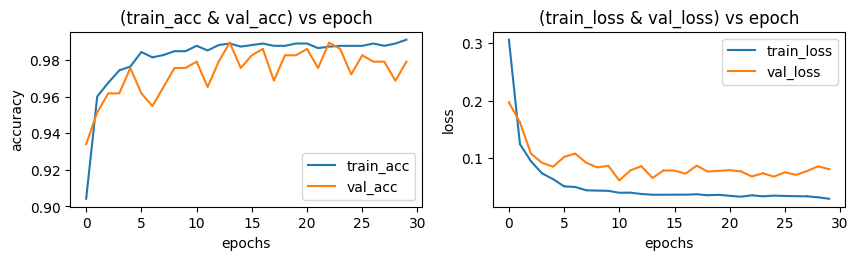

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()


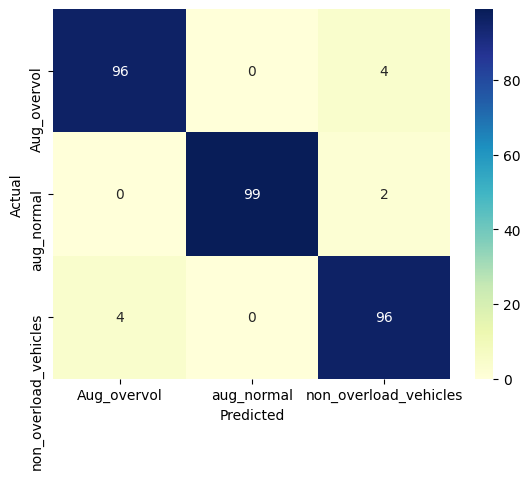

test accuracy: 96.67774086378738


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Aug_overvol', 'aug_normal', 'non_overload_vehicles']

ROC AUC score: 0.9750490049379948


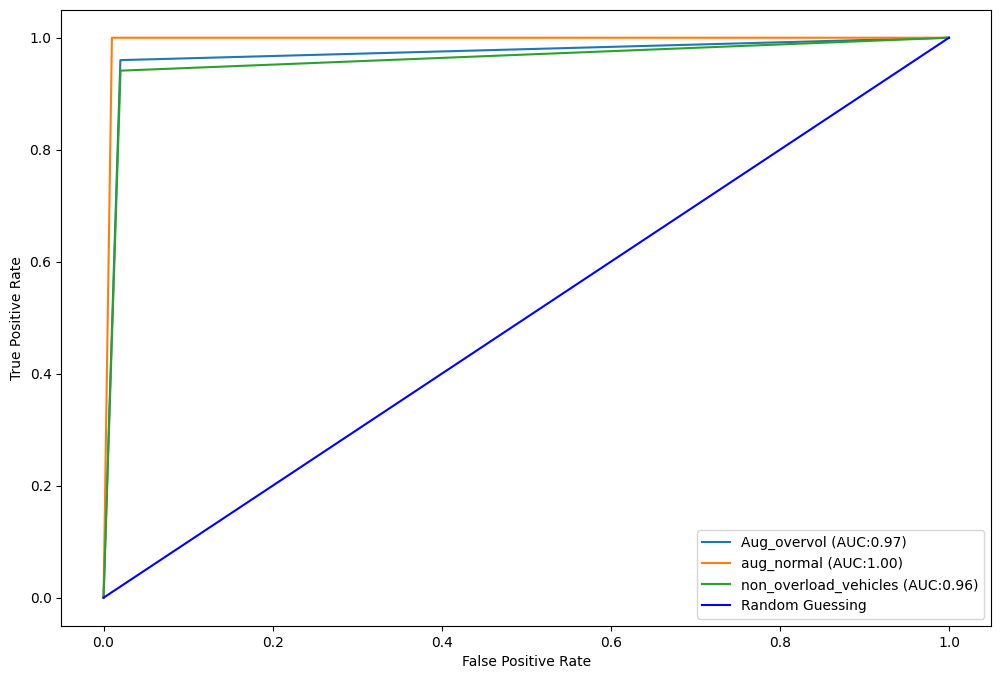

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#for image augmentation 

In [ ]:
import os
import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

In [ ]:

#Lets define functions for each operation
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [ ]:
#to find the number of images in a file

In [ ]:
APP_FOLDER = 'G:/TARP/test/non_overload_vehicles'
#APP_FOLDER = "C:/Users/DHANVANTH/SAMSUNG/y"
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total number of files',totalFiles)


Searching in :  G:/TARP/test/non_overload_vehicles
Total number of files 100
